# UNDERSTANDING DECISION TREES & ENSEMBLE METHODS USING NEW YORK CITY TAXI FARE PREDICTION DATASET
--- 

**Problem Statement**: You are tasked with predicting the fare amount (inclusive of tolls) for a taxi ride in New York City given the pickup and dropoff locations. While you can get a basic estimate based on just the distance between the two points, this will result in an RMSE of \$5-$8, depending on the model used. Your challenge is to do better than this using Machine Learning techniques!


In [1]:
from IPython.display import HTML
html1 = '<img src="https://images.unsplash.com/photo-1573225935973-40b81f6e39e6?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=500&q=60" \
width="1200" height="900" align="center"/>'
HTML(html1)

### Download the data

Let's use Kaggle API to download the data.

In [2]:
!kaggle competitions download -c new-york-city-taxi-fare-prediction

100%|█████████████████████████████████████▉| 1.56G/1.56G [08:15<00:00, 6.05MB/s]
100%|██████████████████████████████████████| 1.56G/1.56G [08:15<00:00, 3.38MB/s]


Let's unzip the taxi file

In [3]:
!unzip new-york-city-taxi-fare-prediction.zip

Archive:  new-york-city-taxi-fare-prediction.zip
  inflating: GCP-Coupons-Instructions.rtf  
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')

### Read the data

The taxiing dataset contains 55M rows. Let us read 5M rows for faster computing.

In [5]:
%%time
import pandas as pd

taxi = pd.read_csv("train.csv",nrows=5000000)

CPU times: user 10.6 s, sys: 982 ms, total: 11.6 s
Wall time: 12.2 s


In [6]:
taxi.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [7]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 8 columns):
key                  object
fare_amount          float64
pickup_datetime      object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      int64
dtypes: float64(5), int64(1), object(2)
memory usage: 305.2+ MB


Convert pickup_datetime from Object to Datetime object.

In [8]:
%%time
taxi['pickup_datetime']=pd.to_datetime(taxi['pickup_datetime'],format='%Y-%m-%d %H:%M:%S UTC')
taxi.head()

CPU times: user 19.6 s, sys: 247 ms, total: 19.9 s
Wall time: 20.5 s


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1


In [9]:
taxi.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.000000e+06,5.000000e+06,5.000000e+06,4.999964e+06,4.999964e+06,5.000000e+06
mean,1.134080e+01,-7.250678e+01,3.991974e+01,-7.250652e+01,3.991725e+01,1.684695e+00
std,9.820175e+00,1.280970e+01,8.963509e+00,1.284777e+01,9.486767e+00,1.331854e+00
min,-1.000000e+02,-3.426609e+03,-3.488080e+03,-3.412653e+03,-3.488080e+03,0.000000e+00
25%,6.000000e+00,-7.399206e+01,4.073491e+01,-7.399139e+01,4.073404e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075315e+01,1.000000e+00
75%,1.250000e+01,-7.396711e+01,4.076712e+01,-7.396367e+01,4.076811e+01,2.000000e+00
max,1.273310e+03,3.439426e+03,3.310364e+03,3.457622e+03,3.345917e+03,2.080000e+02


We can observe that

1). Min fare amount is negative.

2). Min and Max longitude and latitude look unreal.

3). Min passenger count is 0.

We are fixing them now.

1). New York city longitudes are around -74 and latitudes are around 41.

2). Remove 0 passenger count.

3). The initial charge is $2.5, so we are removing fare amount smaller than this amount.

In [10]:
taxi = taxi[((taxi['pickup_longitude'] > -78) & (taxi['pickup_longitude'] < -70)) & 
            ((taxi['dropoff_longitude'] > -78) & (taxi['dropoff_longitude'] < -70)) & 
            ((taxi['pickup_latitude'] > 37) & (taxi['pickup_latitude'] < 45)) & 
            ((taxi['dropoff_latitude'] > 37) & (taxi['dropoff_latitude'] < 45)) & 
            (taxi['passenger_count'] > 0) & (taxi['fare_amount'] >= 2.5)]

Check for Missing Values

In [11]:
taxi[pd.isnull(taxi)].sum()

key                  0.0
fare_amount          0.0
pickup_datetime      0.0
pickup_longitude     0.0
pickup_latitude      0.0
dropoff_longitude    0.0
dropoff_latitude     0.0
passenger_count      0.0
dtype: float64

### EDA

##### Distribution of Trip Fare

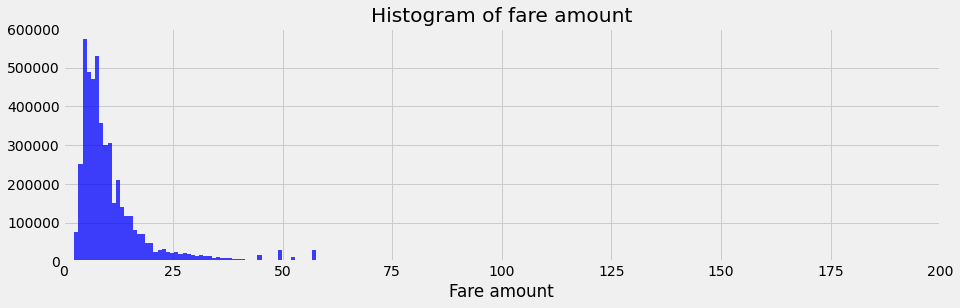

In [12]:
plt.figure(figsize = (14, 4))
n, bins, patches = plt.hist(taxi.fare_amount, 1000, facecolor='blue', alpha=0.75)
plt.xlabel('Fare amount')
plt.title('Histogram of fare amount')
plt.xlim(0, 200)
plt.show();

The above graph also shows that most of the fare amount is small.

In [13]:
taxi.groupby('fare_amount').size().nlargest(10)

fare_amount
6.5     237317
4.5     200433
8.5     183203
5.7     142304
5.3     142293
6.1     138084
4.9     138049
6.9     127239
10.5    124046
7.3     119606
dtype: int64

Interesting, the most common fare amount are very small at only 6.5 and 4.5, they are very short rides.

Passenger Count

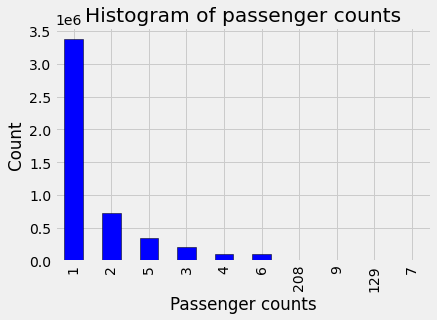

In [14]:
taxi['passenger_count'].value_counts().plot.bar(color = 'b', edgecolor = 'k');
plt.title('Histogram of passenger counts'); plt.xlabel('Passenger counts'); plt.ylabel('Count');

In [15]:
taxi.groupby('passenger_count').size()

passenger_count
1      3386066
2      723885 
3      214918 
4      103907 
5      346169 
6      103547 
7      1      
9      2      
129    1      
208    2      
dtype: int64

Based on the above discovery, we are going to remove taxi rides with passenger_count > 6.

In [16]:
taxi = taxi.loc[taxi['passenger_count'] <= 6]

In [17]:
taxi.groupby('passenger_count').size()

passenger_count
1    3386066
2    723885 
3    214918 
4    103907 
5    346169 
6    103547 
dtype: int64

In [18]:
taxi.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,4.878492e+06,4.878492e+06,4.878492e+06,4.878492e+06,4.878492e+06,4.878492e+06
mean,1.133318e+01,-7.397526e+01,4.075092e+01,-7.397438e+01,4.075129e+01,1.690347e+00
std,9.726842e+00,4.324985e-02,3.374853e-02,4.194506e-02,3.676411e-02,1.306014e+00
min,2.500000e+00,-7.790248e+01,3.703126e+01,-7.797089e+01,3.703126e+01,1.000000e+00
25%,6.000000e+00,-7.399228e+01,4.073654e+01,-7.399158e+01,4.073558e+01,1.000000e+00
50%,8.500000e+00,-7.398210e+01,4.075335e+01,-7.398061e+01,4.075385e+01,1.000000e+00
75%,1.250000e+01,-7.396833e+01,4.076754e+01,-7.396535e+01,4.076840e+01,2.000000e+00
max,9.520000e+02,-7.000039e+01,4.473220e+01,-7.000227e+01,4.472755e+01,6.000000e+00


### Baseline Model

To be quick, let's create a baseline model, without Machine learning, just a simple rate calculation

In [19]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(taxi, test_size=0.3, random_state=42)

In [20]:
import numpy as np
import shutil

def distance_between(lat1, lon1, lat2, lon2):
  # Haversine formula to compute distance 
  dist = np.degrees(np.arccos(np.sin(np.radians(lat1)) * np.sin(np.radians(lat2)) + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.cos(np.radians(lon2 - lon1)))) * 60 * 1.515 * 1.609344
  return dist

def estimate_distance(df):
  return distance_between(df['pickup_latitude'], df['pickup_longitude'], df['dropoff_latitude'], df['dropoff_longitude'])

def compute_rmse(actual, predicted):
  return np.sqrt(np.mean((actual - predicted)**2))

def print_rmse(df, rate, name):
  print("{1} RMSE = {0}".format(compute_rmse(df['fare_amount'], rate * estimate_distance(df)), name))


In [21]:
rate = train['fare_amount'].mean() / estimate_distance(train).mean()

print("Rate = ${0}/km".format(rate))
print_rmse(train, rate, 'Train')
print_rmse(test, rate, 'Test')

/Users/nikhilkashyap/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in arccos
  


Rate = $2.565030371270007/km
Train RMSE = 9.827321395580382
Test RMSE = 10.060946393969688


This baseline model gets us RMSE for test set at $10.0. We expect ML achieve better than this.

### Feature Engineering

1). Extract information from datetime (day of week, month, hour, day). Taxi fares change day/night or on weekdays/holidays.

2). The distance from pickup to dropoff. The longer the trip, the higher the price.

3). Add columns indicating distance from pickup or dropoff coordinates to JFK. Trips from/to JFK have a flat fare at $52.

Getting distance between two points based on latitude and longitude using haversine formula. https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas/29546836#29546836

In [22]:
taxi['year'] = taxi.pickup_datetime.dt.year
taxi['month'] = taxi.pickup_datetime.dt.month
taxi['day'] = taxi.pickup_datetime.dt.day
taxi['weekday'] = taxi.pickup_datetime.dt.weekday
taxi['hour'] = taxi.pickup_datetime.dt.hour

In [23]:
taxi.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,weekday,hour
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,0,17
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,1,16
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,3,0
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,21,5,4
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,9,1,7


In [24]:
from math import radians, cos, sin, asin, sqrt
import numpy as np

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c  # 6371 is Radius of earth in kilometers. Use 3956 for miles
    return km

taxi['distance'] = haversine_np(taxi['pickup_latitude'], taxi['pickup_longitude'], taxi['dropoff_latitude'] , taxi['dropoff_longitude'])

In [25]:
taxi.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,weekday,hour,distance
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,0,17,0.410442
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,1,16,4.628504
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,3,0,1.001022
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,21,5,4,0.910440
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,9,1,7,1.361021


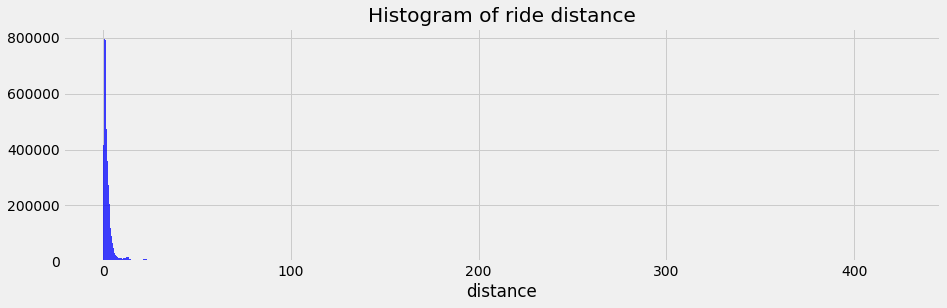

In [26]:
plt.figure(figsize = (14, 4))
n, bins, patches = plt.hist(taxi.distance, 1000, facecolor='blue', alpha=0.75)
plt.xlabel('distance')
plt.title('Histogram of ride distance')
plt.show();

In [27]:
taxi['distance'].describe()

count    4.878492e+06
mean     2.724107e+00
std      4.274640e+00
min      0.000000e+00
25%      8.530987e-01
50%      1.551748e+00
75%      2.831016e+00
max      4.246739e+02
Name: distance, dtype: float64

In [28]:
taxi = taxi.loc[taxi['distance'] > 0]

Official NYC yellow taxis have a flat rate fee from JFK to Manhattan for $52 (plus tolls and tip), Add columns indicating distance from pickup or dropoff coordinates to JFK.

In [29]:
JFK_coord = (40.6413, -73.7781)

pickup_JFK = haversine_np(taxi['pickup_latitude'], taxi['pickup_longitude'], JFK_coord[0], JFK_coord[1]) 
dropoff_JFK = haversine_np(JFK_coord[0], JFK_coord[1], taxi['dropoff_latitude'], taxi['dropoff_longitude'])

In [30]:
taxi['JFK_distance'] = pd.concat([pickup_JFK, dropoff_JFK], axis=1).min(axis=1)

In [31]:
taxi['JFK_distance'].describe()

count    4.826440e+06
mean     2.100062e+01
std      4.558035e+00
min      2.121178e-02
25%      2.027439e+01
50%      2.206172e+01
75%      2.314999e+01
max      4.559050e+02
Name: JFK_distance, dtype: float64

In [32]:
taxi.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,weekday,hour,distance,JFK_distance
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,0,17,0.410442,7.396914
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,1,16,4.628504,22.786805
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,3,0,1.001022,23.054156
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,21,5,4,0.910440,23.415331
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,9,1,7,1.361021,20.336452


In [33]:
del taxi['pickup_datetime']
del taxi['key']

### Model Building

**Linear Regression**

In [34]:
from sklearn.model_selection import train_test_split
y = taxi['fare_amount']
X = taxi.drop(columns=['fare_amount'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [35]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [36]:
from sklearn.metrics import mean_squared_error

print("Test RMSE: %.3f" % mean_squared_error(y_test, y_pred) ** 0.5)

Test RMSE: 6.018


**Decision Trees**

In [37]:
%%time
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(max_depth=2)
dt.fit(X, y)

CPU times: user 12.4 s, sys: 749 ms, total: 13.2 s
Wall time: 14.3 s


DecisionTreeRegressor(max_depth=2)

In [38]:
y_pred = dt.predict(X_test)

In [39]:
print("Test RMSE: %.3f" % mean_squared_error(y_test, y_pred) ** 0.5)

Test RMSE: 5.686


Ensemble methods combine several decision trees classifiers to produce better predictive performance than a single decision tree classifier. The main principle behind the ensemble model is that a group of weak learners come together to form a strong learner, thus increasing the accuracy of the model.

Bagging is a way to decrease the variance in the prediction by generating additional data for training from dataset using combinations with repetitions to produce multi-sets of the original data. 

Boosting is an iterative technique which adjusts the weight of an observation based on the last classification. If an observation was classified incorrectly, it tries to increase the weight of this observation.

**Random Forest**

In [40]:
%%time
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

CPU times: user 10min 1s, sys: 5.53 s, total: 10min 7s
Wall time: 10min 46s


In [41]:
print("Test RMSE: %.3f" % mean_squared_error(y_test, y_pred) ** 0.5)

Test RMSE: 5.665


#### Light GBM

In [42]:
import lightgbm as lgb

params = {
        'learning_rate': 0.75,
        'application': 'regression',
        'max_depth': 3,
        'num_leaves': 100,
        'verbosity': -1,
        'metric': 'RMSE',
    }

In [43]:
train_set = lgb.Dataset(X_train, y_train, silent=True)

In [44]:
%%time
lb = lgb.train(params, train_set = train_set, num_boost_round=300)

CPU times: user 1min 37s, sys: 4.01 s, total: 1min 41s
Wall time: 44.2 s


In [45]:
y_pred = lb.predict(X_test, num_iteration = lb.best_iteration)

In [46]:
print("Test RMSE: %.3f" % mean_squared_error(y_test, y_pred) ** 0.5)

Test RMSE: 3.729
